In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn import svm
import pickle

Using TensorFlow backend.


In [2]:
# convert raw .dat file to  csv using curate_db.py
# file has to exist in db/udb_1yr.dat
# !python curate_db.py 

In [3]:
all_dat = pd.read_csv('./curated.csv', index_col=0)

# sift out pwrs
all_dat = all_dat.loc[all_dat['reactor_type'] == 'PWR']
# only get assemblies with enrichment bigger than 1.5 and bunrup higher than 10,000
all_dat = all_dat.loc[(all_dat['init_enr'] > 1.5) & (all_dat['bu'] > 10000)]

# separate training and testing set
row_num = all_dat.shape[0]
cutoff = int(row_num * 0.6)
train_dat = all_dat.iloc[:cutoff, :]
test_dat = all_dat.iloc[cutoff:, :]


In [4]:
# get all the isotopes, sorted by A
def get_name(f):
    z = ''
    for i in f:
        if i.isalpha():
            z += i
    return z

def get_a(f):
    z = ''
    for i in f:
        if i.isdigit():
            z += i
    return int(z)

iso_list = list(train_dat)[5:]
print(iso_list)
# set the isotopes to categories:
fp = []
bred_fissile = []
u235 = []
nottru = []
tru = []

for iso in iso_list:
    if iso == 'other':
        continue
    if iso == 'u-235':
        u235.append(iso)
    elif iso in ['pu-239', 'u-233']:
        bred_fissile.append(iso)
    elif get_a(iso) < 200:
        fp.append(iso)
    elif get_name(iso) in ['np', 'pu', 'am', 'cm']:
        tru.append(iso)
    else:
        nottru.append(iso)

category = {'u235': u235,
            'bred_fissile': bred_fissile,
            'fp': fp,
            'tru': tru,
            'nottru': nottru}

print(category)

['zr-95', 'zr-93', 'ra-226', 'ru-103', 'ru-106', 'sb-124', 'sb-125', 'pu-238', 'pu-239', 'np-237', 'nb-95', 'pa-231', 'pd-107', 'pm-147', 'pu-240', 'pu-241', 'pu-244', 'pu-242', 'i-129', 'h-3', 'kr-85', 'nb-94', 'cm-248', 'cs-134', 'cs-135', 'cm-245', 'cm-244', 'cm-246', 'cm-247', 'eu-152', 'cs-137', 'eu-154', 'eu-155', 'am-241', 'am-242m', 'am-243', 'cf-251', 'cf-249', 'ag-108m', 'ag-110m', 'ac-227', 'cm-243', 'cm-242', 'c-14', 'ce-144', 'u-234', 'u-235', 'u-236', 'y-90', 'u-238', 'th-229', 'tc-99', 'sm-151', 'se-79', 'sr-90', 'sn-126', 'th-232', 'th-230', 'u-232', 'u-233', 'other']
{'u235': ['u-235'], 'bred_fissile': ['pu-239', 'u-233'], 'fp': ['zr-95', 'zr-93', 'ru-103', 'ru-106', 'sb-124', 'sb-125', 'nb-95', 'pd-107', 'pm-147', 'i-129', 'h-3', 'kr-85', 'nb-94', 'cs-134', 'cs-135', 'eu-152', 'cs-137', 'eu-154', 'eu-155', 'ag-108m', 'ag-110m', 'c-14', 'ce-144', 'y-90', 'tc-99', 'sm-151', 'se-79', 'sr-90', 'sn-126'], 'tru': ['pu-238', 'np-237', 'pu-240', 'pu-241', 'pu-244', 'pu-242', 

## Visualize Data

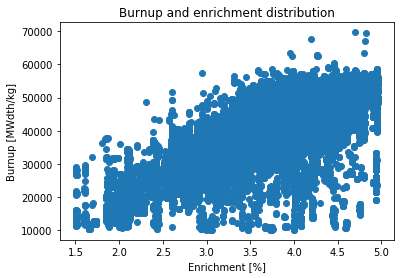

In [5]:
# visualize 
plt.scatter(all_dat['init_enr'], all_dat['bu'])
plt.xlabel('Enrichment [%]')
plt.ylabel('Burnup [MWdth/kg]')
plt.title('Burnup and enrichment distribution')
plt.savefig('./images/enr_bu.png', format='png')
plt.show()




u235
u-235
0.283270566976 3.14828537477


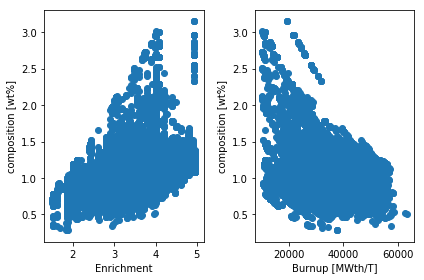

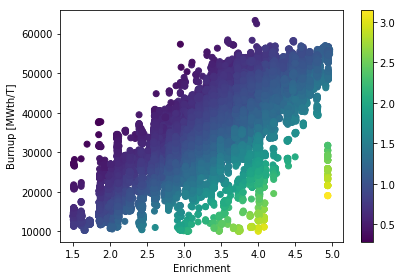




bred_fissile
pu-239
0.357448383787 0.911063059539


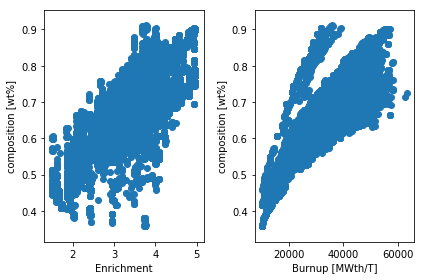

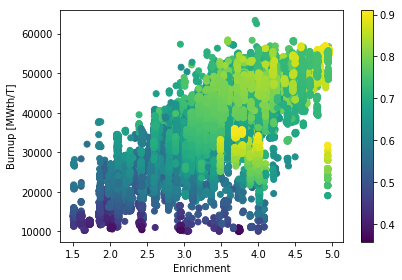

u-233
9.84842331643e-08 7.12614438043e-07


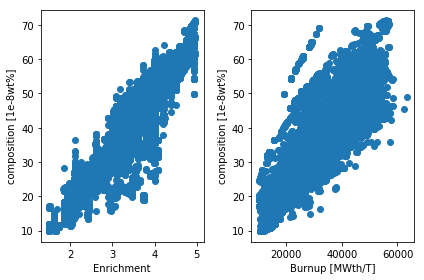

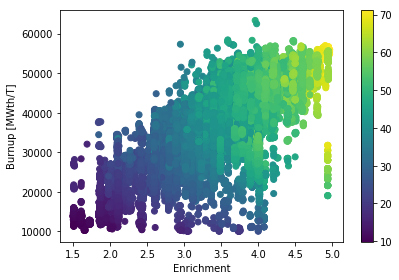




fp
zr-95
3.64268701827e-05 0.000365168346446


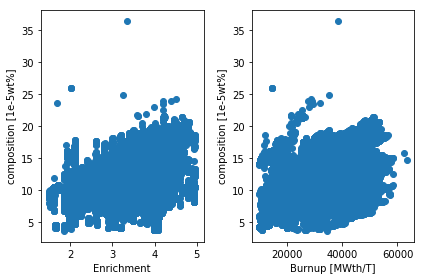

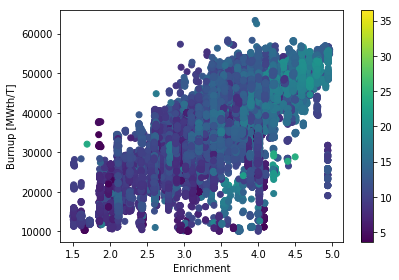

zr-93
0.0258610324083 0.139968326255


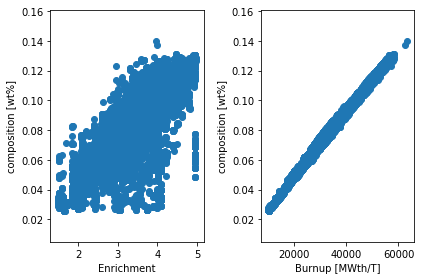

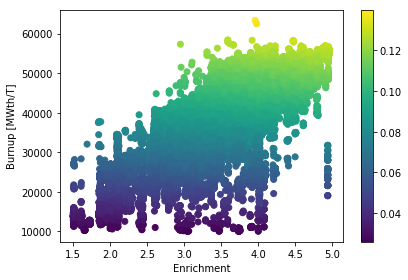

ru-103
1.62023083083e-06 2.04526399636e-05


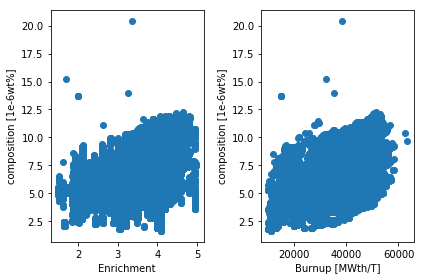

In [ ]:
## visualize how each isotope is correlated with burnup / enrichment
def plot_side_by_side(x1, y1, x2, y2, xlabel1, xlabel2, iso_name):
    
    axes = plt.gca()
    min_ = min(y1)
    max_ = max(y1)
    if max_ < 1e-3:
        where_e = str(min_).index('e')
        power = abs(int(str(min_)[where_e+1:]))
        alpha = 10**power
    else:
        alpha = 1
        power = 0
    print(min_, max_)
    y1_ = y1 * alpha
    y2_ = y2 * alpha
    axes.set_ylim([min_, max_])
    plt.subplot(1, 2, 1)
    plt.scatter(x1, y1_)
    plt.xlabel(xlabel1)
    if power != 0:
        plt.ylabel('composition [1e-' + str(power) + 'wt%]')
    else:
        plt.ylabel('composition [wt%]')

    plt.subplot(1, 2, 2)
    plt.scatter(x2, y2_)
    plt.xlabel(xlabel2)
    if power != 0:
        plt.ylabel('composition [1e-' + str(power) + 'wt%]')
    else:
        plt.ylabel('composition [wt%]')
    
    plt.tight_layout()
    plt.savefig('images/isos/' + iso_name + '_sub.png', format='png')
    plt.show()
    plt.close()

    plt.scatter(x1,x2, c=y1_)
    plt.xlabel(xlabel1)
    plt.ylabel(xlabel2)
    plt.tight_layout()
    plt.colorbar()
    plt.savefig('images/isos/' + iso_name + '_tot.png', format='png')
    plt.show()
    plt.close()
    
    
# show two plots (subfigs) with x = [burnup, enrichment] and y = isotope composition
x1 = list(train_dat['init_enr'])
x2 = list(train_dat['bu'])
for key, val in category.items():
    print('\n\n')
    print(key)
    for iso in val:
        y = np.array(train_dat[iso])
        print(iso)
        plot_side_by_side(x1, y, x2, y, 'Enrichment', 'Burnup [MWth/T]', iso)

In [ ]:
# see cf-251 distribution
print(max(all_dat['cf-251']))
print(min(all_dat['cf-251']))
fig = plt.figure()
ax = plt.gca()
ax.scatter(list(all_dat['bu']), all_dat['cf-251'])
ax.set_yscale('log')
plt.ylim(1e-19, 1e-9)
plt.show()
plt.close()

In [6]:
pd.set_option('display.max_columns', 500)
all_dat.describe()

,total_mass,init_enr,bu,zr-95,zr-93,ra-226,ru-103,ru-106,sb-124,sb-125,pu-238,pu-239,np-237,nb-95,pa-231,pd-107,pm-147,pu-240,pu-241,pu-244,pu-242,i-129,h-3,kr-85,nb-94,cm-248,cs-134,cs-135,cm-245,cm-244,cm-246,cm-247,eu-152,cs-137,eu-154,eu-155,am-241,am-242m,am-243,cf-251,cf-249,ag-108m,ag-110m,ac-227,cm-243,cm-242,c-14,ce-144,u-234,u-235,u-236,y-90,u-238,th-229,tc-99,sm-151,se-79,sr-90,sn-126,th-232,th-230,u-232,u-233,other
count,104551.000000,104551.000000,104551.000000,104551.000000,104551.000000,1.045510e+05,104551.000000,104551.000000,1.045510e+05,104551.000000,104551.000000,104551.000000,104551.000000,104551.000000,1.045510e+05,104551.000000,104551.000000,104551.000000,104551.000000,1.045510e+05,104551.000000,104551.000000,104551.000000,104551.000000,1.045510e+05,1.045510e+05,104551.000000,104551.000000,1.045510e+05,104551.000000,1.045510e+05,1.045510e+05,1.045510e+05,104551.000000,104551.000000,104551.000000,104551.000000,104551.000000,104551.000000,1.045510e+05,1.045510e+05,1.045510e+05,1.045510e+05,1.045510e+05,1.045510e+05,104551.000000,104551.000000,104551.000000,104551.000000,104551.000000,104551.000000,104551.000000,104551.000000,1.045510e+05,104551.000000,104551.000000,104551.000000,104551.000000,104551.000000,1.045510e+05,1.045510e+05,1.045510e+05,1.045510e+05,104551.000000
mean,433.676089,3.730356,39847.564350,0.000133,0.092772,6.053472e-12,0.000008,0.009197,9.851432e-08,0.001032,0.027869,0.706012,0.060556,0.000156,5.983635e-08,0.028158,0.014850,0.257824,0.170807,5.755530e-06,0.063551,0.019088,0.000006,0.003022,1.886131e-07,8.814604e-08,0.012161,0.055497,6.032374e-04,0.007415,5.939067e-05,1.032660e-06,1.956511e-06,0.140743,0.003301,0.000901,0.015526,0.000116,0.017659,2.575626e-10,8.750271e-10,2.630614e-08,4.057353e-05,2.399473e-12,6.515530e-05,0.000499,0.000011,0.014024,0.018134,1.049757,0.481230,0.000015,93.008324,1.999894e-10,0.091808,0.001609,0.000549,0.059426,0.002564,5.339886e-07,2.282966e-07,1.578052e-07,4.481894e-07,3.562912
std,38.353292,0.694683,9459.265971,0.000035,0.020963,4.903590e-12,0.000002,0.002566,3.814770e-08,0.000250,0.011207,0.082974,0.017593,0.000042,2.481011e-08,0.007206,0.002614,0.042621,0.033880,3.189751e-06,0.019523,0.004505,0.000002,0.000774,6.027881e-08,9.678992e-08,0.004415,0.015395,4.058182e-04,0.004050,4.772289e-05,9.745306e-07,8.356700e-07,0.033336,0.001050,0.000256,0.003930,0.000056,0.007274,3.396203e-10,1.076656e-09,1.007224e-08,1.577909e-05,1.433295e-12,3.628094e-05,0.000224,0.000003,0.004042,0.002782,0.251365,0.111151,0.000003,1.274462,1.750683e-10,0.019834,0.000296,0.000123,0.013749,0.000618,1.290737e-07,7.243413e-08,7.095075e-08,1.150787e-07,0.849846
min,194.608000,1.502000,10054.800000,0.000036,0.025861,4.206064e-13,0.000002,0.001167,6.282474e-09,0.000197,0.000940,0.357448,0.009600,0.000043,5.049477e-09,0.003475,0.003838,0.054295,0.025331,1.600251e-08,0.002097,0.004081,0.000001,0.000768,2.048591e-08,1.895896e-13,0.000985,0.008259,1.965126e-07,0.000010,3.576363e-09,1.175578e-11,3.140720e-07,0.035723,0.000231,0.000120,0.001546,0.000003,0.000135,2.688453e-17,4.487813e-16,7.633054e-10,6.772428e-08,1.107763e-13,1.897754e-07,0.000007,0.000002,0.002931,0.007359,0.256737,0.133667,0.000004,89.383058,1.874264e-12,0.025974,0.000657,0.000152,0.016075,0.000489,1.325304e-07,4.990889e-08,4.311190e-09,9.848423e-08,0.890515
25%,415.074500,3.290000,34017.000000,0.000107,0.080247,3.585596e-12,0.000006,0.007290,6.939784e-08,0.000858,0.020086,0.661804,0.049187,0.000126,4.575577e-08,0.023682,0.013133,0.238478,0.151654,3.160634e-06,0.051125,0.016308,0.000005,0.002489,1.439801e-07,1.775357e-08,0.008904,0.046412,2.760061e-04,0.004180,2.131363e-05,2.800474e-07,1.482326e-06,0.119816,0.002629,0.000738,0.013575,0.000086,0.012400,3.316040e-11,1.402883e-10,1.914024e-08,2.879461e-05,1.585808e-12,4.363539e-05,0.000389,0.000009,0.011036,0.016379,0.904328,0.411917,0.000013,92.048023,9.623039e-11,0.080217,0.001432,0.000475,0.050586,0.002182,4.538437e-07,1.859885e-07,1.088197e-07,3.769252e-07,3.038381
50%,43

In [9]:
all_dat.index

Int64Index([163647, 163648, 163649, 163650, 163651, 163652, 163653, 163654,
            163655, 163656,
            ...
            416970, 416971, 416972, 416973, 416974, 419865, 419866, 419867,
            419868, 419872],
           dtype='int64', length=104551)